In [2]:
import json
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split
import sqlite3
import nltk
import spacy
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import umap
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

In [3]:
df_reviews_4yrs_open = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/df_reviews_last_4yrs_open.csv')



/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df_business_4yrs_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163300 entries, 0 to 163299
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    163300 non-null  int64  
 1   business_id   163300 non-null  object 
 2   name          163300 non-null  object 
 3   address       155907 non-null  object 
 4   city          163298 non-null  object 
 5   state         163300 non-null  object 
 6   postal_code   162939 non-null  object 
 7   latitude      163300 non-null  float64
 8   longitude     163300 non-null  float64
 9   stars         163300 non-null  float64
 10  review_count  163300 non-null  int64  
 11  is_open       163300 non-null  int64  
 12  attributes    139458 non-null  object 
 13  categories    162834 non-null  object 
 14  hours         134741 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 18.7+ MB


In [5]:
df_business_4yrs_open['review_count'].value_counts()

3       25906
4       14132
5       10986
6        8852
7        7430
        ...  
1445        1
2648        1
3414        1
2855        1
1791        1
Name: review_count, Length: 1292, dtype: int64

In [6]:
df_bus_select =  df_business_4yrs_open[df_business_4yrs_open['review_count']>10]

In [7]:
df_bus_select['review_count'].value_counts()

11      4114
12      3555
13      3232
14      2893
15      2707
        ... 
1204       1
1268       1
2164       1
2228       1
1791       1
Name: review_count, Length: 1284, dtype: int64

In [12]:
threshold = 0.1
review_by_state = pd.DataFrame(df_bus_select['state'].value_counts())
states_select = review_by_state[review_by_state['state'] > threshold*review_by_state.max()['state']]
states_select

state
AZ  25777
NV  18208
ON  11548
NC   6122
OH   5436
PA   4298
QC   3020

In [13]:
df_reviews_4yrs_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464626 entries, 0 to 4464625
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Unnamed: 0   object 
 1   review_id    object 
 2   user_id      object 
 3   business_id  object 
 4   stars        float64
 5   useful       float64
 6   funny        float64
 7   cool         float64
 8   text         object 
 9   date         object 
 10  year         float64
dtypes: float64(5), object(6)
memory usage: 374.7+ MB


In [14]:
df_rev_bus_raw = df_reviews_4yrs_open.merge(df_bus_select, on = 'business_id', how= 'inner')

In [17]:
df_rev_bus_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4135344 entries, 0 to 4135343
Data columns (total 26 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0_x  object 
 1   review_id     object 
 2   user_id       object 
 3   business_id   object 
 4   stars_x       float64
 5   useful        float64
 6   funny         float64
 7   cool          float64
 8   text          object 
 9   date          object 
 10  year          float64
 11  Unnamed: 0_y  int64  
 12  name          object 
 13  address       object 
 14  city          object 
 15  state         object 
 16  postal_code   object 
 17  latitude      float64
 18  longitude     float64
 19  stars_y       float64
 20  review_count  int64  
 21  is_open       int64  
 22  attributes    object 
 23  categories    object 
 24  hours         object 
 25  text length   int64  
dtypes: float64(8), int64(4), object(14)
memory usage: 851.9+ MB


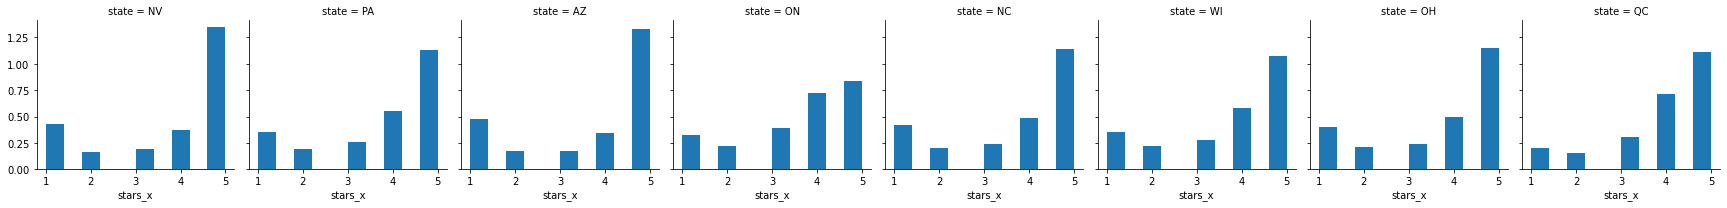

In [30]:
df_rev_bus_raw['text length'] = df_rev_bus_raw['text'].apply(len)
g = sns.FacetGrid(data=df_rev_bus_raw[df_rev_bus_raw['state'].isin(['AZ', 'NV', 'OH', 'ON', 'PA', 'QC', 'NC', 'WI'])], col='state')
g.map(plt.hist, 'stars_x', density=True, rwidth = 2)

In [ ]:
df_rev_bus_raw.shape

In [ ]:
df_rev_bus_raw = df_rev_bus_raw.rename(columns = {'stars_x': 'stars'})

In [ ]:
df_rev_bus_select = df_rev_bus_raw.loc[df_rev_bus_raw['state'].isin(states_select.index)==True]

In [ ]:
df_rev_bus_select.state.value_counts()

In [ ]:
df_food_rev = df_rev_bus_select[df_rev_bus_select['categories'].str.contains('Restaurant')|
                 df_rev_bus_select['categories'].str.contains('Coffee & Tea')]

In [ ]:
df_food = df_food_rev.copy()
catlist_clean = df_food['categories'].str.replace(' ', '' ).str.replace(',', ', ')

In [ ]:
df_food['categories_filtered']= catlist_clean

In [ ]:
food_categories = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/Yelp_food_categories.csv')
food_categories.info()

In [ ]:
food_types = food_categories['Food_types'].dropna().str.strip().str.replace(' ', '')
ethnicities = food_categories['Ethnicities'].dropna().str.strip().str.replace(' ', '')
venue_types = food_categories['Venue_type'].dropna().str.strip().str.replace(' ', '')

In [ ]:
type_list = []

for x in df_food['categories_filtered']:
    sublist = []
    for i in food_types:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        type_list.append(['Undefined'])
    else:
        type_list.append(sublist)  

print(len(type_list))
print(df_food.shape[0])


In [ ]:
venue_list = []

for x in  df_food['categories_filtered']:
    sublist = []
    for i in venue_types:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        venue_list.append(['Restaurant'])
    else:
        venue_list.append(sublist)  

print(len(venue_list))
print(df_food.shape[0])


In [ ]:
ethnicity_list = []

for x in  df_food['categories_filtered']:
    sublist = []
    for i in ethnicities:
        if i in x:
            sublist.append(i)
    
    if len(sublist) == 0:
        ethnicity_list.append(['Undefined'])
    else:
        ethnicity_list.append(sublist)  
print(len(ethnicity_list))
print(df_food.shape[0])


In [ ]:
df_food['food_type'] = type_list
df_food['ethnicity'] = ethnicity_list
df_food['venue'] = venue_list


In [ ]:
df_food['food_comb'] = (df_food['food_type']+df_food['ethnicity']+df_food['venue']).apply(lambda x: ', '.join(x))
df_food['food_comb'] = df_food['food_comb'].str.replace('Undefined,', '')


In [ ]:
df_food_clean = df_food.drop(columns = ['categories'])
df_food_clean['food_type'] = df_food_clean['food_type'].apply(lambda x: ', '.join(x))
df_food_clean['venue'] = df_food_clean['venue'].apply(lambda x: ', '.join(x))
df_food_clean['ethnicity']= df_food_clean['ethnicity'].apply(lambda x: ', '.join(x))

In [ ]:
(df_food_clean['postal_code']=='').value_counts()

In [ ]:
df_food_clean['postal_code'].replace('', np.nan, inplace = True)
df_food_clean.dropna(inplace = True)

In [ ]:
df_food_clean.reset_index(drop=True, inplace= True)


In [ ]:
df_food_clean = df_food_clean.rename(columns = {'stars_x':'stars'})

In [ ]:
df_food_clean

In [ ]:
df_food_clean.drop(['Unnamed: 0_x'], axis = True, inplace = True)

In [ ]:
df_food_clean.to_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/capstone4_files/df_food_clean_rev.csv')

In [ ]:
df_food_clean['review_count'].value_counts()